### Necessary Packages

In [7]:
import os
import sys
sys.path.append("../..")
import torch
import pandas as pd
import numpy as np
import imagesize
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import dotenv
from PIL import Image
from tqdm.notebook import tqdm
from src.transforms import make_patches,ImageResizer
from torchvision.transforms import ToTensor

In [24]:
style.use(style.available[11])

In [3]:
tqdm.pandas()

### Loading envirement variables

In [4]:
ROI_LATEST = dotenv.get_key(dotenv.find_dotenv(), "ROI_LATEST")
DATA_DIR = dotenv.get_key(dotenv.find_dotenv(), "DATA_DIR")
ROI_DATA_DIR = dotenv.get_key(dotenv.find_dotenv(), "ROI_DATA_DIR")

print(ROI_LATEST)
print(DATA_DIR)
print(ROI_DATA_DIR)

Key ROI_LATEST not found in d:\AIDS\S2\Project\Breast Cancer Detection\Breast-Cancer-Detection\.env.


/media/abdelnour/69cfbde5-2170-4791-a258-c8cc9021aea8/roi-dataset/BRACS_RoI/latest_version
/home/abdelnour/Documents/4eme_anne/S2/projet/data
/media/abdelnour/69cfbde5-2170-4791-a258-c8cc9021aea8/roi-dataset


In [5]:
DESCRIPTION_DF_PATH = os.path.join(DATA_DIR, "description_df.csv")
print(DESCRIPTION_DF_PATH)

/media/abdelnour/69cfbde5-2170-4791-a258-c8cc9021aea8/roi-dataset/description_df.csv


### Loading the description dataframe

In [6]:
def build_df(data_dir):

    splits = os.listdir(data_dir)
    
    df = {
        "path": [],
        "split": [],
        "category": [],
    }
    
    for split in splits:

        split_dir = os.path.join(data_dir, split)
        categories = os.listdir(split_dir)

        for category in categories:

            category_dir = os.path.join(split_dir,category)

            for roi in os.listdir(category_dir):
                roi_path = os.path.join(category_dir, roi)
                df["path"].append(roi_path)
                df["split"].append(split)
                df["category"].append(category)

    df = pd.DataFrame(df)
    df["size"] = df.path.apply(os.path.getsize)
    df["resolution"] = df.path.progress_apply(imagesize.get)
    df["width"] = df["resolution"].apply(lambda x : x[0])
    df["height"] = df["resolution"].apply(lambda x : x[1])

    mapper = {
        "0_N":"benign",
        "1_PB":"benign",
        "2_UDH":"benign",
        "3_FEA":"atypical",
        "4_ADH":"atypical",
        "5_DCIS":"malignant",
        "6_IC":"malignant"
    }

    df["path"] = df["path"] \
        .apply(lambda x : x.replace(data_dir,'')) \
        .apply(lambda x : x[len(os.path.sep):])

    df["label"] = df["category"].map(mapper)

    df["patches_count"] = df["resolution"] \
        .apply(lambda r : ImageResizer.get_new_dimensions(r[0], r[1])) \
        .apply(lambda r : int((r[0] / 224) * (r[1] / 224)))

    return df

In [7]:
df = None

if not os.path.exists(DESCRIPTION_DF_PATH):
    df = build_df(ROI_LATEST)
    df.to_csv(DESCRIPTION_DF_PATH,index=False)
else:
    df = pd.read_csv(DESCRIPTION_DF_PATH)
    df["resolution"] = df["resolution"].apply(
        lambda x : (int(x[1:-1].split(',')[0]),int(x[1:-1].split(',')[1]))
    )

In [8]:
df.head()

,path,split,category,size,resolution,width,height,label,patches_count
0,train/3_FEA/BRACS_1811_FEA_35.png,train,3_FEA,1747625,"(806, 795)",806,795,atypical,16
1,train/3_FEA/BRACS_747_FEA_4.png,train,3_FEA,8365724,"(1441, 2355)",1441,2355,atypical,66
2,train/3_FEA/BRACS_1771_FEA_63.png,train,3_FEA,3321943,"(959, 1246)",959,1246,atypical,24
3,train/3_FEA/BRACS_754_FEA_24.png,train,3_FEA,1370381,"(581, 867)",581,867,atypical,12
4,train/3_FEA/BRACS_1877_FEA_12.png,train,3_FEA,1176420,"(669, 617)",669,617,atypical,9


### Plots

<Axes: xlabel='split', ylabel='count'>

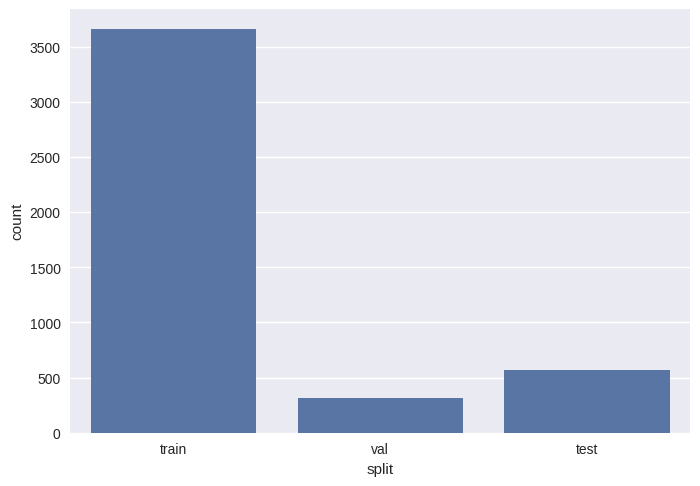

In [25]:
sns.countplot(data=df, x='split')

<Axes: xlabel='category', ylabel='count'>

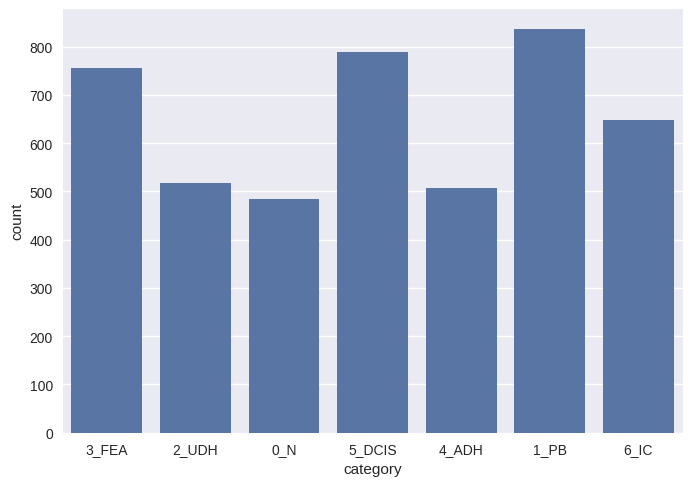

In [26]:
sns.countplot(data=df, x='category')

<Axes: xlabel='label', ylabel='count'>

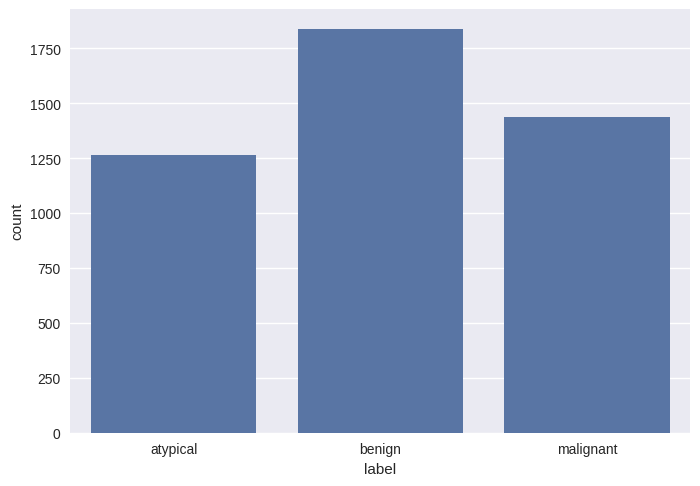

In [27]:
sns.countplot(data=df, x='label')

<Axes: xlabel='split', ylabel='count'>

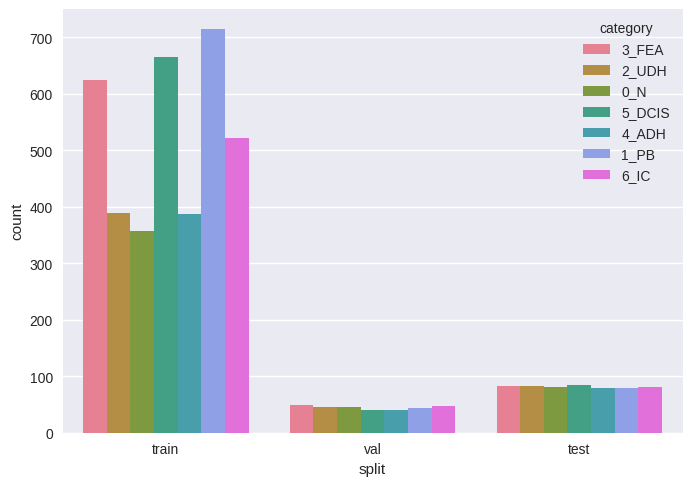

In [28]:
sns.countplot(data=df, x='split', hue='category')

<Axes: xlabel='split', ylabel='count'>

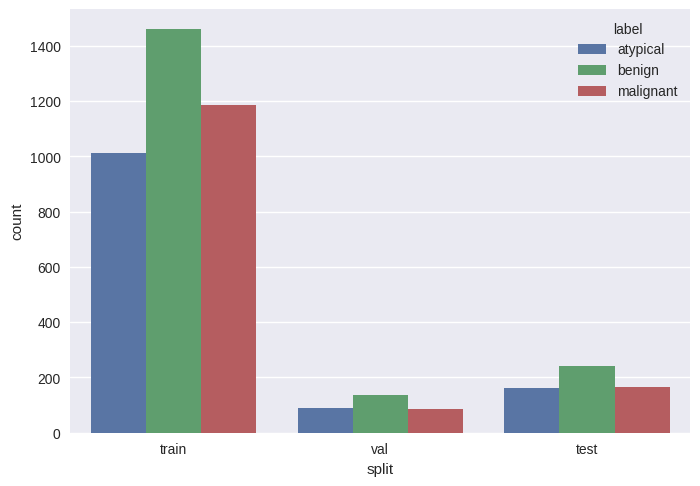

In [29]:
sns.countplot(data=df, x='split', hue='label')

### Frequency Plots after patching

In [30]:
df["patches_count"].sum()

404424

<Axes: xlabel='split', ylabel='patches_count'>

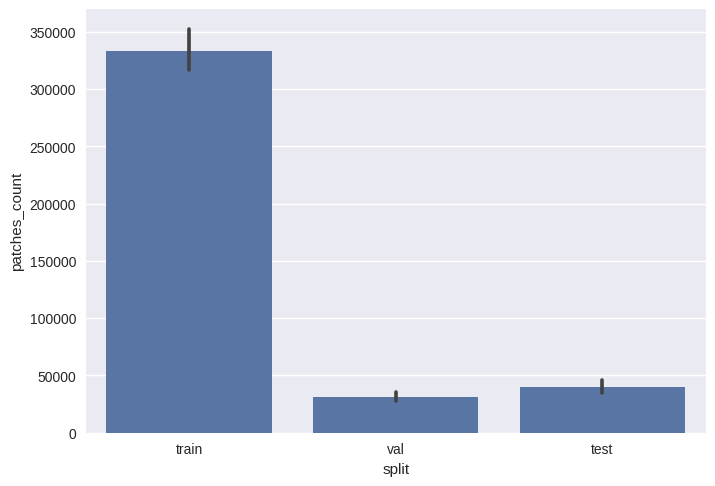

In [31]:
sns.barplot(data=df, x="split", y="patches_count", estimator=np.sum)

<Axes: xlabel='category', ylabel='patches_count'>

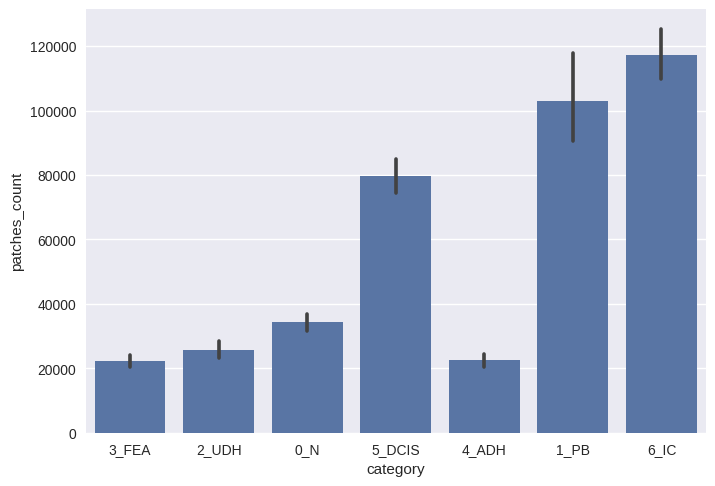

In [32]:
sns.barplot(data=df, x="category", y="patches_count", estimator=np.sum)

<Axes: xlabel='label', ylabel='patches_count'>

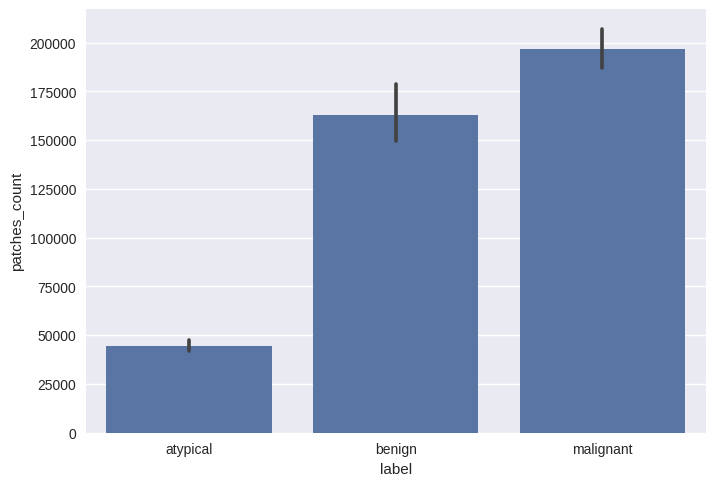

In [33]:
sns.barplot(data=df, x="label", y="patches_count", estimator=np.sum)

<Axes: xlabel='split', ylabel='patches_count'>

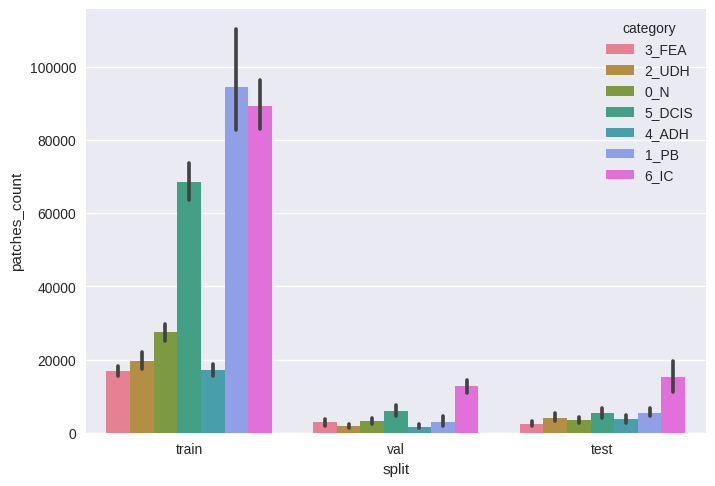

In [34]:
sns.barplot(data=df, x="split", y="patches_count", hue="category", estimator=np.sum)

<Axes: xlabel='split', ylabel='patches_count'>

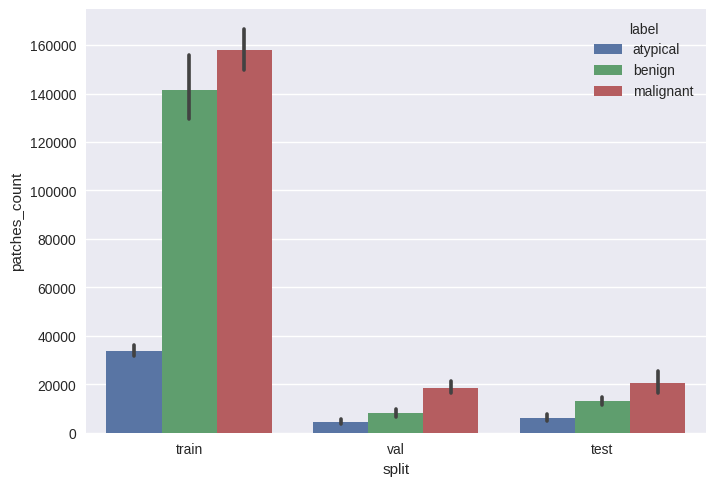

In [35]:
sns.barplot(data=df, x="split", y="patches_count", hue="label", estimator=np.sum)

### Visualizing the images

In [19]:
def load_image(infilename) :
    img = Image.open(infilename)
    return img

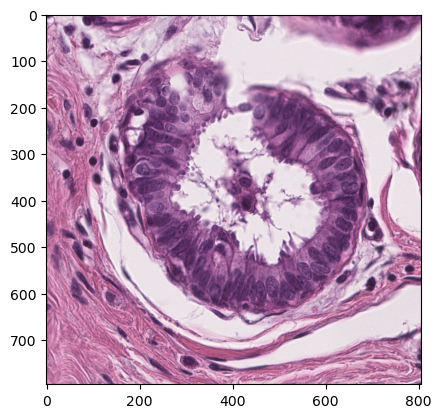

In [21]:
path = os.path.join(ROI_LATEST, df.path.iloc[0])
test_img = load_image(path)
plt.imshow(test_img)

### Image Patching

In [22]:
resizer = ImageResizer()
resized_img = resizer(test_img)
tensor_img = ToTensor().__call__(resized_img)
patches = make_patches(tensor_img, patch_height=224,patch_width=224)
print(f"langth = {len(patches)}, type = {type(patches)}")

langth = 16, type = <class 'list'>


In [23]:
def plot_paches(patches : list[torch.Tensor]) -> None:

    fig, axes = plt.subplots(nrows=len(patches))

    fig.set_size_inches(5,30)

    i = 0
    
    for cell in axes:
        cell.imshow(patches[i].permute(1,2,0))
        i += 1

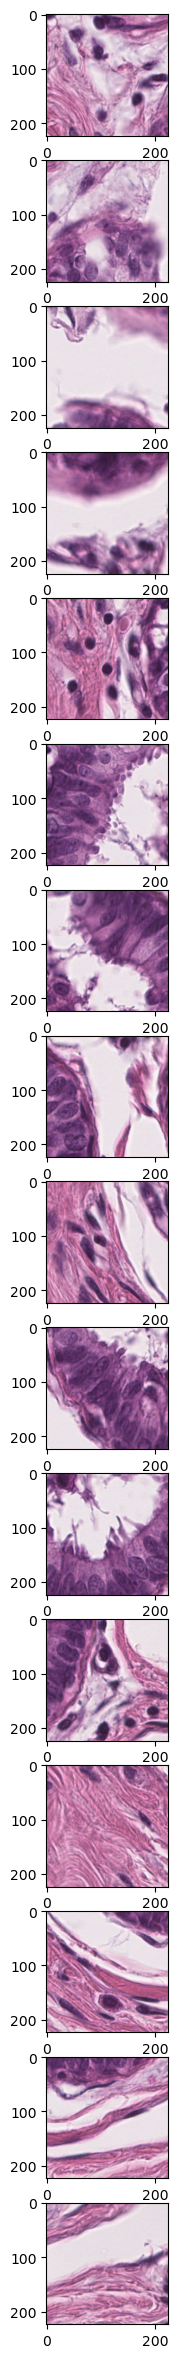

In [24]:
plot_paches(patches)

In [18]:
#print the number of patches for each split and for each category
patches_per_split = df.groupby("split").patches_count.sum()
patches_per_category = df.groupby("category").patches_count.sum()
patches_per_label = df.groupby("label").patches_count.sum()

print(f"patches per split = {patches_per_split}")
print(f"patches per category = {patches_per_category}")
print(f"patches per label = {patches_per_label}")

patches per split = split
test      39892.0
train    333274.0
val       31258.0
Name: patches_count, dtype: float64
patches per category = category
0_N        34238.0
1_PB      102981.0
2_UDH      25647.0
3_FEA      22113.0
4_ADH      22448.0
5_DCIS     79780.0
6_IC      117217.0
Name: patches_count, dtype: float64
patches per label = label
atypical      44561.0
benign       162866.0
malignant    196997.0
Name: patches_count, dtype: float64
